#**Install packages**

In [1]:
!pip install langchain_core langchain_community langgraph langchain_groq

In [2]:
# pydantic for structured o/p
from pydantic import BaseModel, Field

# typing
from typing import TypedDict, Annotated, Sequence
import operator
import json

# Graph
from langgraph.graph import MessagesState, StateGraph, END, START
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, SystemMessage, AnyMessage, ToolMessage
from langgraph.graph.message import add_messages

from langgraph.prebuilt import ToolNode, tools_condition

#tools
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

#memory
from langgraph.checkpoint.memory import MemorySaver
# model and embedding
from langchain_groq import ChatGroq


#**LLM**

##**Get Env variables**

In [3]:
from google.colab import userdata

groq_api_key = userdata.get('groq_api_key')
TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')

In [4]:
import getpass
import os

os.environ["TAVILY_API_KEY"] = getpass.getpass()

··········


In [5]:
# llm model
llm=ChatGroq(groq_api_key=groq_api_key,
             model="llama-3.3-70b-versatile")

#**Tools**

In [ ]:
@tool
def multiply(first_number:int, second_number:int)->int:
    """multiply two integer number"""
    return first_number * second_number


In [ ]:
multiply({"first_number":24,"second_number":364})


<ipython-input-7-31132ee08b29>:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  multiply({"first_number":24,"second_number":364})


8736

In [ ]:
tavily_tool = TavilySearchResults()


In [ ]:
@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily=TavilySearchResults()
    result=tavily.invoke(query)
    return result

##**Bind tools with the llm model**

In [ ]:
tools=[search,multiply]
model_with_tools = llm.bind_tools(tools)


In [ ]:
tool_mapping={tool.name: tool for tool in tools}


In [ ]:
tool_mapping


{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x78c5260ec7c0>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x78c5262b2b60>)}

In [ ]:
response = model_with_tools.invoke("who is a current president of USA?")
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_j9g3', 'function': {'arguments': '{"query": "current president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 279, 'total_tokens': 295, 'completion_time': 0.058181818, 'prompt_time': 0.036835927, 'queue_time': 0.119879489, 'total_time': 0.095017745}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_fcc3b74982', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-df82bb79-5820-4c43-9bb0-14e5aea8f25a-0', tool_calls=[{'name': 'search', 'args': {'query': 'current president of USA'}, 'id': 'call_j9g3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 279, 'output_tokens': 16, 'total_tokens': 295})

In [ ]:
tool_details=response.additional_kwargs.get("tool_calls")
tool_details

[{'id': 'call_j9g3',
  'function': {'arguments': '{"query": "current president of USA"}',
   'name': 'search'},
  'type': 'function'}]

In [ ]:
tool_details[0]["function"]["name"]

'search'

In [ ]:
tool_details[0]["function"]["arguments"]


'{"query": "current president of USA"}'

In [ ]:
json.loads(tool_details[0]["function"]["arguments"])


{'query': 'current president of USA'}

In [ ]:
response = tool_mapping[tool_details[0]["function"]["name"]].invoke(json.loads(tool_details[0]["function"]["arguments"]))
response

[{'url': 'https://www.usa.gov/presidents',
  'content': 'Vice president of the United States\nThe vice president of the United States presides over the U.S. Senate and takes over the role of president of the United States if the president is unable to perform his or her duties. President of the United States\nThe president of the United States is the:\nCurrent president\nThe 46th and current president of the United States is Joseph R. Biden, Jr. First lady\nThe First lady of the United States has traditionally been the wife or other close female relative of the president of the United States. Requirements to be eligible to become president\nAccording to Article II of the U.S. Constitution, the president must:\nLearn about the U.S. presidential election process.\n If the vice president is not able to fulfill the duties of president, the role is passed to another leader in the order of presidential succession.\n'},
 {'url': 'https://en.wikipedia.org/wiki/List_of_Presidents_of_the_United_

#**Graph**

##**AgentState**

In [ ]:
class AgentState(TypedDict):
      messages: Annotated[list[AnyMessage], operator.add]


##**Node functions**

In [ ]:
def invoke_model(state:AgentState):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}

###**Tool node + Custom human in the loop**

In [ ]:
def invoke_tool(state:AgentState):
    tool_details= state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]

    if tool_details is None:
        raise Exception("no tool call found")

    print(f'Selected tool: {tool_details.get("function").get("name")}')

    if tool_details.get("function").get("name")=="search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise Exception("web search discard")

    response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]}


In [ ]:
def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "perform tool calling"
    else:
        return "end"

##**Graph workflow**

In [ ]:
graph = StateGraph(AgentState)
graph.add_node("ai_assistant", invoke_model)
graph.add_node("tool", invoke_tool)

graph.add_conditional_edges("ai_assistant", router, {"perform tool calling": "tool",
                                                     "end": END})
graph.add_edge("tool", END)
graph.set_entry_point("ai_assistant")
app = graph.compile()


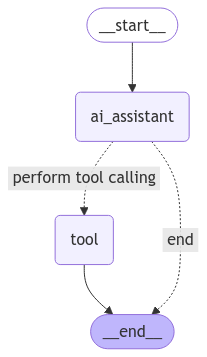

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

#**Testing workflow**

In [ ]:
for s in app.stream({"messages": ["who is upcoming president of USA?"]}):
    print(list(s.values())[0])
    print("----")


{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qvff', 'function': {'arguments': '{"query": "upcoming president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 278, 'total_tokens': 295, 'completion_time': 0.085983419, 'prompt_time': 0.058774772, 'queue_time': 0.6928625909999999, 'total_time': 0.144758191}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_c0cfa69934', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-08faac86-1acd-4feb-965e-a2af572f2cbe-0', tool_calls=[{'name': 'search', 'args': {'query': 'upcoming president of USA'}, 'id': 'call_qvff', 'type': 'tool_call'}], usage_metadata={'input_tokens': 278, 'output_tokens': 17, 'total_tokens': 295})]}
----
Selected tool: search
[y/n] continue with expensive web search?y
{'messages': [[{'url': 'https://www.nbcnews.com/politics/2024-election/trump-wins-election-president-harris-defeat-2024-rac

In [ ]:
for s in app.stream({"messages": ["what do you know about Egypt clubs?"]}):
    print(list(s.values())[0])
    print("----")


{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pv7t', 'function': {'arguments': '{"query": "Egypt clubs"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 279, 'total_tokens': 293, 'completion_time': 0.070303942, 'prompt_time': 0.054489198, 'queue_time': 0.31528038199999997, 'total_time': 0.12479314}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3884478861', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e4bbefc2-f947-4164-ad9c-cd120535a43d-0', tool_calls=[{'name': 'search', 'args': {'query': 'Egypt clubs'}, 'id': 'call_pv7t', 'type': 'tool_call'}], usage_metadata={'input_tokens': 279, 'output_tokens': 14, 'total_tokens': 293})]}
----
Selected tool: search
[y/n] continue with expensive web search?y
{'messages': [[{'url': 'https://framey.io/blog/egypt-nightlife-20-must-visit-bars-and-dance-clubs/', 'content': "Egypt Nightlife: 20 Must-Visit Bars > 

#**Built in Human in the loop**

##**Tools**

In [ ]:
tavily=TavilySearchResults()
tools = [tavily]
llm_with_tools = llm.bind_tools(tools)


In [ ]:
tool_node = ToolNode(tools=tools)

##**Memory**

In [ ]:
memory = MemorySaver()


##**node functions**

In [ ]:
def ai_assistant(state: AgentState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


In [ ]:
graph_builder = StateGraph(AgentState)

graph_builder.add_node("ai_assistant", ai_assistant)
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge(START, "ai_assistant")

graph_builder.add_conditional_edges(
    "ai_assistant",
    tools_condition, # in-built function from langgraph
)
graph_builder.add_edge("tools", "ai_assistant")

In [ ]:
app2 = graph_builder.compile(
    checkpointer=memory,         # memory
    interrupt_before=["tools"],  # Human in the loop

    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

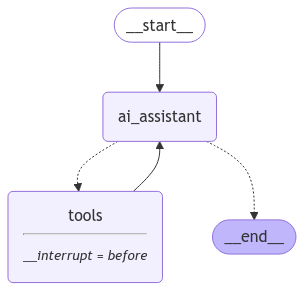

In [ ]:

from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

##**Config**
its like creating a session , each thread will mantian
1. history
2. states

In [ ]:
config = {"configurable": {"thread_id": "1"}}

##**Testing**

In [ ]:
user_input = "who is a top scorer for liverpool?"

In [ ]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values")
for event in events:
    if "messages" in event:
        print(event["messages"][-1])

('user', 'who is a top scorer for liverpool?')
content='' additional_kwargs={'tool_calls': [{'id': 'call_b169', 'function': {'arguments': '{"query": "Liverpool top scorer"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 2558, 'total_tokens': 2578, 'completion_time': 0.072727273, 'prompt_time': 0.288529643, 'queue_time': 0.024062585999999997, 'total_time': 0.361256916}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_fcc3b74982', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-3c191a4a-834d-4a9b-8e4a-e67274029c33-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Liverpool top scorer'}, 'id': 'call_b169', 'type': 'tool_call'}] usage_metadata={'input_tokens': 2558, 'output_tokens': 20, 'total_tokens': 2578}


now the workflow is interrputed before `tools node`
we can acess the states by `.get_state` method and passing the `config`

In [ ]:
snapshot = app2.get_state(config)


In [ ]:
snapshot.next


('tools',)

In [ ]:
last_message=snapshot.values["messages"][-1]
last_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b169', 'function': {'arguments': '{"query": "Liverpool top scorer"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 2558, 'total_tokens': 2578, 'completion_time': 0.072727273, 'prompt_time': 0.288529643, 'queue_time': 0.024062585999999997, 'total_time': 0.361256916}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_fcc3b74982', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3c191a4a-834d-4a9b-8e4a-e67274029c33-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Liverpool top scorer'}, 'id': 'call_b169', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2558, 'output_tokens': 20, 'total_tokens': 2578})

In [ ]:
last_message.tool_calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'Liverpool top scorer'},
  'id': 'call_b169',
  'type': 'tool_call'}]

In [ ]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = app2.stream(None, config, stream_mode="values")


In [ ]:
for event in events:
    if "messages" in event:
        print(event["messages"][-1])

content='' additional_kwargs={'tool_calls': [{'id': 'call_b169', 'function': {'arguments': '{"query": "Liverpool top scorer"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 2558, 'total_tokens': 2578, 'completion_time': 0.072727273, 'prompt_time': 0.288529643, 'queue_time': 0.024062585999999997, 'total_time': 0.361256916}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_fcc3b74982', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-3c191a4a-834d-4a9b-8e4a-e67274029c33-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Liverpool top scorer'}, 'id': 'call_b169', 'type': 'tool_call'}] usage_metadata={'input_tokens': 2558, 'output_tokens': 20, 'total_tokens': 2578}
content='[{"url": "https://www.thisisanfield.com/2024/09/liverpool-fc-top-10-goalscorers-of-all-time-mo-salah-ranks/", "content": "Henry \'Harry\' Chambers was Liverpool\'s top scorer in al

In [ ]:
user_input = "who is the top scorer this season"

config = {"configurable": {"thread_id": "1"}}

In [ ]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    if "messages" in event:
        print(event["messages"][-1])

('user', 'who is the top scorer this season')
content='' additional_kwargs={'tool_calls': [{'id': 'call_h6vf', 'function': {'arguments': '{"query": "Liverpool top scorer this season"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 3176, 'total_tokens': 3198, 'completion_time': 0.08, 'prompt_time': 0.389185992, 'queue_time': 0.07466975800000003, 'total_time': 0.469185992}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4196e754db', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-7c31a30d-9dc4-449d-b05e-54a8e7c89877-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Liverpool top scorer this season'}, 'id': 'call_h6vf', 'type': 'tool_call'}] usage_metadata={'input_tokens': 3176, 'output_tokens': 22, 'total_tokens': 3198}


In [ ]:
snapshot = app2.get_state(config)
snapshot.next


('tools',)

In [ ]:
last_message=snapshot.values["messages"][-1]
last_message.tool_calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'Liverpool top scorer this season'},
  'id': 'call_h6vf',
  'type': 'tool_call'}]

In [ ]:
events = app2.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        print(event["messages"][-1])

content='' additional_kwargs={'tool_calls': [{'id': 'call_h6vf', 'function': {'arguments': '{"query": "Liverpool top scorer this season"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 3176, 'total_tokens': 3198, 'completion_time': 0.08, 'prompt_time': 0.389185992, 'queue_time': 0.07466975800000003, 'total_time': 0.469185992}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4196e754db', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-7c31a30d-9dc4-449d-b05e-54a8e7c89877-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Liverpool top scorer this season'}, 'id': 'call_h6vf', 'type': 'tool_call'}] usage_metadata={'input_tokens': 3176, 'output_tokens': 22, 'total_tokens': 3198}
content='[{"url": "https://www.statmuse.com/fc/ask/top-scorers-for-liverpool-this-season", "content": "Mohamed Salah has the most goals by a Liverpool player in the Premier 

In [ ]:
snapshot = app2.get_state(config)
snapshot

StateSnapshot(values={'messages': [['user', 'who is a current president of USA?'], AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_n1cg', 'function': {'arguments': '{"query": "current president of USA"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 286, 'total_tokens': 307, 'completion_time': 0.105808186, 'prompt_time': 0.059969898, 'queue_time': 0.11443092400000002, 'total_time': 0.165778084}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_c0cfa69934', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-72c878af-2cc5-4ffc-939a-821dda91abb7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current president of USA'}, 'id': 'call_n1cg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 286, 'output_tokens': 21, 'total_tokens': 307}), ToolMessage(content='[{"url": "https://www.usa.gov/presidents", "content": "Vice presi

In [ ]:
snapshot.next


()

#**Example for human interruption**

In [ ]:
user_input = "give me the recent news of it?"
config = {"configurable": {"thread_id": "1"}}

In [ ]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    if "messages" in event:
        print(event["messages"][-1])

('user', 'give me the recent news of it?')
content='' additional_kwargs={'tool_calls': [{'id': 'call_4d0k', 'function': {'arguments': '{"query": "Mohamed Salah recent news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 3660, 'total_tokens': 3682, 'completion_time': 0.08, 'prompt_time': 0.58074547, 'queue_time': 0.32166468000000004, 'total_time': 0.66074547}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_fcc3b74982', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-988e0be6-8900-4712-9204-2a01b73f209a-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Mohamed Salah recent news'}, 'id': 'call_4d0k', 'type': 'tool_call'}] usage_metadata={'input_tokens': 3660, 'output_tokens': 22, 'total_tokens': 3682}


In [ ]:
snapshot=app2.get_state(config)


In [ ]:
snapshot.next

('tools',)

In [ ]:
current_message = snapshot.values["messages"][-1]
current_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'Mohamed Salah recent news'},
  'id': 'call_4d0k',
  'type': 'tool_call'}]

In [ ]:
tool_call_id = current_message.tool_calls[0]["id"]
tool_call_id

'call_4d0k'

In [ ]:
answer = "Salah breaks the record of Frank Lampard"
new_messages = [
    ToolMessage(content=answer, tool_call_id=tool_call_id),
    AIMessage(content=answer),
]

In [ ]:
app2.update_state(
    config,
    {"messages": new_messages},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe185c-58fa-6308-8011-0c03510c6a23'}}

In [ ]:
print(app2.get_state(config).values["messages"][-1:])


[AIMessage(content='Salah breaks the record of Frank Lampard', additional_kwargs={}, response_metadata={})]


#**Putting all together**

In [6]:
memory = MemorySaver()

##**Agent state**

In [7]:
from uuid import uuid4
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage

"""
In previous examples we've annotated the `messages` state key
with the default `operator.add` or `+` reducer, which always
appends new messages to the end of the existing messages array.

Now, to support replacing existing messages, we annotate the
`messages` key with a customer reducer function, which replaces
messages with the same `id`, and appends them otherwise.
"""
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    # assign ids to messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
            # replace any existing messages with the same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # append any new messages to the end
            merged.append(message)
    return merged

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages]

##**Agent class**

In [8]:
class Agent:
    def __init__(self, model, tools, system="", checkpointer=None):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(
            checkpointer=checkpointer,
            interrupt_before=["action"]
        )
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        print(state)
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

##**Agent instant, system prompt and llm**

In [9]:
tool = TavilySearchResults(max_results=2)

In [10]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""


# model = ChatOpenAI(model="gpt-3.5-turbo")
model =ChatGroq(groq_api_key=groq_api_key,
             model="llama-3.3-70b-versatile")

# agent instant
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [11]:
messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)
while abot.graph.get_state(thread).next:
    print("\n", abot.graph.get_state(thread),"\n")
    _input = input("proceed?")
    if _input != "y":
        print("aborting")
        break
    for event in abot.graph.stream(None, thread):
        for v in event.values():
            print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='e582f103-2c82-41ec-a9c2-5a5f253a89ab'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mv3q', 'function': {'arguments': '{"query": "Los Angeles weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 349, 'total_tokens': 370, 'completion_time': 0.076363636, 'prompt_time': 0.041850376, 'queue_time': 0.08067443299999999, 'total_time': 0.118214012}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_fcc3b74982', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ec45d021-f3f1-4c4e-90ab-1ffe67533fef-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Los Angeles weather today'}, 'id': 'call_mv3q', 'type': 'tool_call'}], usage_metadata={'input_tokens': 349, 'output_tokens': 21, 'total_tokens': 370})]}
{'messages': [A

#**Modify state**

In [12]:
messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id": "3"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='b75fcfd9-f7a9-460f-9537-986ac918103e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5k2h', 'function': {'arguments': '{"query": "Los Angeles weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 349, 'total_tokens': 370, 'completion_time': 0.105587875, 'prompt_time': 0.067504749, 'queue_time': 1.306107314, 'total_time': 0.173092624}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3884478861', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f3d2eafe-ab1d-4b11-a05b-f728d5332883-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Los Angeles weather today'}, 'id': 'call_5k2h', 'type': 'tool_call'}], usage_metadata={'input_tokens': 349, 'output_tokens': 21, 'total_tokens': 370})]}
{'messages': [AIMessage

In [13]:
current_values = abot.graph.get_state(thread)

In [14]:
current_values.values['messages'][-1]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5k2h', 'function': {'arguments': '{"query": "Los Angeles weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 349, 'total_tokens': 370, 'completion_time': 0.105587875, 'prompt_time': 0.067504749, 'queue_time': 1.306107314, 'total_time': 0.173092624}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3884478861', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f3d2eafe-ab1d-4b11-a05b-f728d5332883-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Los Angeles weather today'}, 'id': 'call_5k2h', 'type': 'tool_call'}], usage_metadata={'input_tokens': 349, 'output_tokens': 21, 'total_tokens': 370})

In [15]:
current_values.values['messages'][-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'Los Angeles weather today'},
  'id': 'call_5k2h',
  'type': 'tool_call'}]

In [16]:
# id
_id = current_values.values['messages'][-1].tool_calls[0]['id']

# modify the current state with a new query with same id
current_values.values['messages'][-1].tool_calls = [
    {'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in SF'},
  'id': _id}
]

In [17]:
abot.graph.update_state(thread, current_values.values)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='b75fcfd9-f7a9-460f-9537-986ac918103e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5k2h', 'function': {'arguments': '{"query": "Los Angeles weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 349, 'total_tokens': 370, 'completion_time': 0.105587875, 'prompt_time': 0.067504749, 'queue_time': 1.306107314, 'total_time': 0.173092624}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3884478861', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f3d2eafe-ab1d-4b11-a05b-f728d5332883-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in SF'}, 'id': 'call_5k2h'}], usage_metadata={'input_tokens': 349, 'output_tokens': 21, 'total_tokens': 370})]}


{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe1987-260c-6011-8002-9fc1e01746b4'}}

In [18]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='b75fcfd9-f7a9-460f-9537-986ac918103e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5k2h', 'function': {'arguments': '{"query": "Los Angeles weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 349, 'total_tokens': 370, 'completion_time': 0.105587875, 'prompt_time': 0.067504749, 'queue_time': 1.306107314, 'total_time': 0.173092624}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3884478861', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f3d2eafe-ab1d-4b11-a05b-f728d5332883-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in SF'}, 'id': 'call_5k2h', 'type': 'tool_call'}], usage_metadata={'input_tokens': 349, 'output_tokens': 21, 'total_tokens': 370})]}, next=

In [19]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in SF'}, 'id': 'call_5k2h', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.775, \'lon\': -122.4183, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1738523038, \'localtime\': \'2025-02-02 11:03\'}, \'current\': {\'last_updated_epoch\': 1738522800, \'last_updated\': \'2025-02-02 11:00\', \'temp_c\': 15.1, \'temp_f\': 59.2, \'is_day\': 1, \'condition\': {\'text\': \'Light rain\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/296.png\', \'code\': 1183}, \'wind_mph\': 19.7, \'wind_kph\': 31.7, \'wind_degree\': 185, \'wind_dir\': \'S\', \'pressure_mb\': 1018.0, \'pressure_in\': 30.05, \'precip_mm\': 2.3, \'precip_in\': 0.09, \'humidity\': 100, \'cloud\': 100, \'feelslike_c\': 15.1, \'f

#**Time travel**

In [20]:
states = []
for state in abot.graph.get_state_history(thread):
    print(state)
    print('--')
    states.append(state)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='b75fcfd9-f7a9-460f-9537-986ac918103e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5k2h', 'function': {'arguments': '{"query": "Los Angeles weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 349, 'total_tokens': 370, 'completion_time': 0.105587875, 'prompt_time': 0.067504749, 'queue_time': 1.306107314, 'total_time': 0.173092624}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3884478861', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f3d2eafe-ab1d-4b11-a05b-f728d5332883-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in SF'}, 'id': 'call_5k2h', 'type': 'tool_call'}], usage_metadata={'input_tokens': 349, 'output_tokens': 21, 'total_tokens': 370}), ToolMes

##**Resume to our earliest state**

In [25]:
to_replay = states[-3]  # the earliest one
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='b75fcfd9-f7a9-460f-9537-986ac918103e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5k2h', 'function': {'arguments': '{"query": "Los Angeles weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 349, 'total_tokens': 370, 'completion_time': 0.105587875, 'prompt_time': 0.067504749, 'queue_time': 1.306107314, 'total_time': 0.173092624}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3884478861', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f3d2eafe-ab1d-4b11-a05b-f728d5332883-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Los Angeles weather today'}, 'id': 'call_5k2h', 'type': 'tool_call'}], usage_metadata={'input_tokens': 349, 'output_tokens': 21, 'total_tokens': 370})]}, n

In [26]:
for event in abot.graph.stream(None, to_replay.config):
    for k, v in event.items():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Los Angeles weather today'}, 'id': 'call_5k2h', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Los Angeles\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 34.0522, \'lon\': -118.2428, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1738522916, \'localtime\': \'2025-02-02 11:01\'}, \'current\': {\'last_updated_epoch\': 1738522800, \'last_updated\': \'2025-02-02 11:00\', \'temp_c\': 14.4, \'temp_f\': 57.9, \'is_day\': 1, \'condition\': {\'text\': \'Mist\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/143.png\', \'code\': 1030}, \'wind_mph\': 2.2, \'wind_kph\': 3.6, \'wind_degree\': 168, \'wind_dir\': \'SSE\', \'pressure_mb\': 1021.0, \'pressure_in\': 30.14, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 84, \'cloud\': 50, \'feelslike_c\': 15.1, \'feelsli

##**go Back in time and modify**

In [27]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='b75fcfd9-f7a9-460f-9537-986ac918103e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5k2h', 'function': {'arguments': '{"query": "Los Angeles weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 349, 'total_tokens': 370, 'completion_time': 0.105587875, 'prompt_time': 0.067504749, 'queue_time': 1.306107314, 'total_time': 0.173092624}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3884478861', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f3d2eafe-ab1d-4b11-a05b-f728d5332883-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Los Angeles weather today'}, 'id': 'call_5k2h', 'type': 'tool_call'}], usage_metadata={'input_tokens': 349, 'output_tokens': 21, 'total_tokens': 370})]}, n

In [28]:
_id = to_replay.values['messages'][-1].tool_calls[0]['id']
to_replay.values['messages'][-1].tool_calls = [{
    'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in LA, accuweather'},
  'id': _id}
                                               ]

In [29]:
branch_state = abot.graph.update_state(to_replay.config, to_replay.values)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='b75fcfd9-f7a9-460f-9537-986ac918103e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5k2h', 'function': {'arguments': '{"query": "Los Angeles weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 349, 'total_tokens': 370, 'completion_time': 0.105587875, 'prompt_time': 0.067504749, 'queue_time': 1.306107314, 'total_time': 0.173092624}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3884478861', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f3d2eafe-ab1d-4b11-a05b-f728d5332883-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'call_5k2h'}], usage_metadata={'input_tokens': 349, 'output_tokens': 21, 'total_tokens': 370})]}


In [30]:
for event in abot.graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'call_5k2h', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Los Angeles\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 34.0522, \'lon\': -118.2428, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1738522966, \'localtime\': \'2025-02-02 11:02\'}, \'current\': {\'last_updated_epoch\': 1738522800, \'last_updated\': \'2025-02-02 11:00\', \'temp_c\': 14.4, \'temp_f\': 57.9, \'is_day\': 1, \'condition\': {\'text\': \'Mist\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/143.png\', \'code\': 1030}, \'wind_mph\': 2.2, \'wind_kph\': 3.6, \'wind_degree\': 168, \'wind_dir\': \'SSE\', \'pressure_mb\': 1021.0, \'pressure_in\': 30.14, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 84, \'cloud\': 50, \'feelslike_c\': 15.1, 

#**add a message to a state at a given time**

In [31]:
_id = to_replay.values['messages'][-1].tool_calls[0]['id']

In [32]:
state_update = {"messages": [ToolMessage(
    tool_call_id=_id,
    name="tavily_search_results_json",
    content="54 degree celcius",
)]}

In [33]:
branch_and_add = abot.graph.update_state(
    to_replay.config,
    state_update,
    as_node="action") # we dont wanna to action node after modifing instead we did the action node job

In [34]:
for event in abot.graph.stream(None, branch_and_add):
    for k, v in event.items():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='b75fcfd9-f7a9-460f-9537-986ac918103e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5k2h', 'function': {'arguments': '{"query": "Los Angeles weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 349, 'total_tokens': 370, 'completion_time': 0.105587875, 'prompt_time': 0.067504749, 'queue_time': 1.306107314, 'total_time': 0.173092624}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3884478861', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f3d2eafe-ab1d-4b11-a05b-f728d5332883-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Los Angeles weather today'}, 'id': 'call_5k2h', 'type': 'tool_call'}], usage_metadata={'input_tokens': 349, 'output_tokens': 21, 'total_tokens': 370}), ToolMessage(content='54 